# Thomas Adams - Velocity Global Project

## Colorado Analysis to determine most suitable place to live.
## Based on Four main features.
- Distance from the West mountain range.
- Distance from Lockheed Martin Space Campus. (Partners Work Location, 40km is currently set)
- Within a user defined distance from a fitness area/gym. (30km is currently set)
- Each town's net change in population to identify a rapidly growing area.


## Import Necessary Packages

In [261]:
# library to handle requests
import requests
# library for data analsysis
import pandas as pd
# library
import wikipedia as wp
import numpy as np
import folium
from pandas.io.json import json_normalize
import json
from IPython.display import display
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans
# import plotting
from matplotlib import pyplot as plt
# import GEO data API
from geopy.geocoders import Nominatim
import geopy.distance
import time
import pickle
import os


## Load the data
#### Scrape data from the table on this page. https://en.wikipedia.org/wiki/List_of_cities_and_towns_in_Colorado
#### Median Age / Demographic data is pulled from Colorado.gov. https://demography.dola.colorado.gov/population/population-totals-municipalities/

In [262]:
def loadData():
    # get cities in colorado
    html = wp.page("List_of_cities_and_towns_in_Colorado").html().encode("UTF-8")
    areas_of_interest = pd.read_html(html)[0]
    areas_of_interest.to_csv('wiki_colorado_3.csv',index=False)

    areas_of_interest = pd.read_csv('optimize_city/wiki_colorado_5.csv')
    
    # get demographic in colorado
    median_age = pd.read_excel('optimize_city/PopulationByAge_co.xlsx')
    
    return areas_of_interest, median_age

## Data Formatting
- Create latitude and longitude columns within the dataFrame.
- Drop unecessary columns
- Drop entries without data.


In [263]:
def format_lat_lon(wgs84_str):
    lat_lon = wgs84_str.split(" / ")[1]
    
    lat_str = lat_lon.split(" ")[0]
    lat = float(lat_str[1:-3]) if lat_str[-1] is 'N' else float(lat_str[1:-3])*-1
    
    lon_str = lat_lon.split(" ")[1]
    lon = float(lon_str[:-3]) if lon_str[-1] is 'E' else float(lon_str[:-3])*-1
    
    return [lat,lon]

In [264]:
def formatData(areas_of_interest):
    areas_of_interest['Latitude'] = areas_of_interest['WGS84'].apply(lambda x : format_lat_lon(x)[0])
    areas_of_interest['Longitude'] = areas_of_interest['WGS84'].apply(lambda x : format_lat_lon(x)[1])

    areas_of_interest = areas_of_interest.drop(['Pop Rank', '2014 Estimate', '2010 Census','Pop Density','Land Area',\
                            'Water Area','Total Area', 'INCITS', 'WGS84','Municipality','Incorporation Date', 'Government', \
                                                        'County', 'Map'], axis=1)
    areas_of_interest = areas_of_interest.dropna(subset=['Change']).reset_index(drop=True)

    return areas_of_interest

## Foursquare API: Pull location data to analyze venues/ammenities.
https://developer.foursquare.com/
#### Radius of 1000m (0.62mi) with a limit of 100 venues per Town.

In [265]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    radius = 1000
    LIMIT = 100

    # Foursquare API Credentials
    CLIENT_ID = '1RAZZUPP43HZQWU5GVPVQMW3SJMCAISY40PU1HKUADFKQE5Y' # your Foursquare ID
    CLIENT_SECRET = 'XJHXGVLZNXIFJVEUMBJPN14P0EU0X3ZSKNSUKYUBTZY4YENR' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version

    print('Your credentails:')
    print('CLIENT_ID: ' + CLIENT_ID)
    print('CLIENT_SECRET:' + CLIENT_SECRET)
    venues_list=[]

    count = 0
    for name, lat, lng in zip(names, latitudes, longitudes):

        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)

        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Dist_Latitude', 
                  'Dist_Longitude', 
                  'Venue', 
                  'Venue_Lat', 
                  'Venue_Long', 
                  'Venue_Category']
    count += 1
    if count > 15:
        time.sleep(50) 
        count = 0
        
    return (nearby_venues)

## Algorithm Development: 
### Determine the most suitable place to live based on the features passed into the machine learning algorithm.
#### Below are the weights assigned to each "feature" along with the equation of the algorithm.



$$
\begin{array}{c}
w_{1} = 300 \\
w_{2} = 50 \\
w_{3} = 15 \\
w_{4} = 0.0425 \\
f(w_{k}) = \frac{w_{1}}{distance_{west}} + w_{2}{0 \choose 1} w^p + w_{3}{0 \choose 1} w^p + w_{4}*population_{change}
\end{array}
$$

In [266]:
def gather_feature_data(areas_of_interest):

    real_proj = pd.DataFrame()
    real_proj['Place Name'] = areas_of_interest['Place Name']
    real_proj['population change'] = areas_of_interest['Change']
    real_proj['population change'] = real_proj['population change'].apply(lambda x: float(str(x).strip('%')))
    real_proj['population change'] = real_proj['population change'].apply(lambda x: float(str(x).strip('+')))

    #dist to west
    idaho_springs_ndx = areas_of_interest['Place Name'] == "Idaho Springs" 
    idaho_springs_lat_lon = (areas_of_interest['Latitude'][idaho_springs_ndx].values[0],\
                             areas_of_interest['Longitude'][idaho_springs_ndx].values[0])

    real_proj['dist from west']=areas_of_interest.apply(lambda row: \
                                           geopy.distance.distance(idaho_springs_lat_lon,\
                                           (row['Latitude'], row['Longitude'])), axis=1).astype(str).str[:-3].astype(float)

    # dist to work / within x miles
    waterton_campus = (39.4935996, -105.0885975)
    real_proj['dist from work']=areas_of_interest.apply(lambda row: \
                                           geopy.distance.distance(waterton_campus,\
                                           (row['Latitude'], row['Longitude'])), axis=1)

    real_proj['close to work']=real_proj['dist from work']<41

    # dist to gym / within x miles
    gym_data = gymClose(areas_of_interest, 30) 
    real_proj['dist to gym'] = gym_data['Gym Dist']

    real_proj['close to gym'] = gym_data['Gym Close']
    
    return real_proj


#### Function that determines if a fitness center is close enough to each town.

In [267]:
def gymClose(locations, max_dist):
# Function to know if gym location 
# is within max dist: True or False
    file_name = 'saved_gym_dist.pkl'
    # set up return data frame
    gym_close = pd.DataFrame(columns =['Place Name', 'Gym Close', 'Gym Dist'])
    gym_close['Place Name'] = locations['Place Name']
    gym_close['Gym Dist'] = 1000 # some outrageous number that wont pass

    if os.path.isfile(file_name):
        print('Found saved pickle file')
        gym_venues = pd.read_pickle(file_name)    
    else:

        # for the places that DO have venue data,
        # find the closest gym distance
        venues = getNearbyVenues(names=locations['Place Name'],
                                 latitudes=locations['Latitude'],
                                 longitudes=locations['Longitude'])
        
        gym_venues = venues[venues['Venue_Category'].str.contains('Gym')].reset_index(drop=True)
        gym_venues.index = np.arange(1, len(gym_venues)+1)

        #gym_venues = gym_venues.loc[gym_venues.groupby("District")["Gym_dist"].idxmin()]
        # end finding closest gym distance
        gym_venues.to_pickle(file_name)  # where to save it, usually as a .pkl

    # replace the gym dist for places that DO have venue data
    for place_ndx in range(gym_close['Place Name'].shape[0]):
        place = gym_close.loc[place_ndx,'Place Name']
        place_lat_lon = (locations.loc[place_ndx, 'Latitude'],locations.loc[place_ndx, 'Longitude'])

        dist_to_gyms = gym_venues.apply(lambda row: \
                         geopy.distance.distance(place_lat_lon,\
                                                 (row['Venue_Lat'], row['Venue_Long'])), axis=1).astype(str).str[:-3].astype(float)

        closest_gym = gym_venues[dist_to_gyms == min(dist_to_gyms)]

        # replace gym dist (defaulted 1000) with the venue gym dist (accurate)
        gym_close.loc[place_ndx,'Gym Dist'] = min(dist_to_gyms)
        # end replace gym dist 
    

    # is the dist less than max (returns True, False)    
    gym_close['Gym Close'] = gym_close['Gym Dist'] <= max_dist

    return gym_close


#### Function that does the equation above to each town to determine a ranking.

In [268]:
def calculateRating(location_features):
    
    # calculate weights for each location
    weight_dist = 300
    weight_work = 50
    weight_demo = 1
    weight_gym = 15
    weight_pop_change = 0.0425

    tot_score = 0;
    dist_score = 0;
    work_score = 0;
    gym_score = 0;
    pop_change_score = 0;
    
    try:
        dist_score = (weight_dist/location_features['dist from west'])
    except:
        dist_score = 1
        
    work_score = (weight_work if location_features['close to work'] else 0)
    gym_score = (weight_gym if location_features['close to gym'] else 0)
    pop_change_score = (weight_pop_change * location_features['population change'])
    tot_score = dist_score + work_score + gym_score + pop_change_score 
    
    return tot_score
               

#### Function that applies the algorithm to the data.

In [269]:
def optimize(location_features):
    
    location_features['rating'] = location_features.apply(lambda row: calculateRating(row), axis=1)      
    location_features = location_features.sort_values(by=['rating'], ascending=False).reset_index(drop=True)        
               
    return location_features

#### Function that creates a map of all the towns in Colorado using the Folium() package.

In [270]:
def createMapView(co_municipality):
    address = 'Denver, CO'

    geolocator = Nominatim(user_agent="denver_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of Denver is {}, {}.'.format(latitude, longitude))

    # create map of resulting co_municipality
    map_co = folium.Map(location=[latitude, longitude], zoom_start=10)

    for lat, lng, place_name in zip(co_municipality['Latitude'], co_municipality['Longitude'], co_municipality['Place Name']):
        label = '{}'.format(place_name)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
                [lat, lng],
                radius=5,
                popup=label,
                color='blue',
                fill=True,
                fill_color='#3186cc',
                fill_opacity=0.7,
                parse_html=False).add_to(map_co)


    return map_co

#### Each towns ratings in a dataFrame, determined from the algorithm.

In [271]:
#areas_of_interest, median_age = loadData()
#areas_of_interest = formatData(areas_of_interest)

# gets all the data for important features
location_features = gather_feature_data(areas_of_interest)
overall_rating_locations = optimize(location_features)
overall_rating_locations.head(260)
#overall_rating_locations.to_excel('ratings.xlsx')

# visual
#createMapView(areas_of_interest)
# visual
#createMapView(overall_rating_locations)


Found saved pickle file


,Place Name,population change,dist from west,dist from work,close to work,dist to gym,close to gym,rating
0,Golden,7.07,25.225771,29.550838737662627 km,True,9.460412,True,77.193075
1,Morrison,0.70,28.910792,17.887989456477833 km,True,17.848111,True,75.406498
2,Arvada,6.71,31.786643,38.13328146462501 km,True,0.954634,True,74.723102
3,Lakewood,4.66,33.658545,22.9337683946409 km,True,7.756865,True,74.111091
4,Wheat Ridge,2.88,34.374113,31.016278877256084 km,True,0.514579,True,73.849898
5,Edgewater,2.30,37.894329,28.645511952330438 km,True,0.322237,True,73.014502
6,Mountain View,5.08,38.500246,31.33812762277209 km,True,0.458953,True,73.008058
7,Bow Mar,6.35,41.232627,15.116828285299205 km,True,4.631732,True,72.545667
8,Central City,9.20,5.274778,49.64101014162365 km,False,6.126827,True,72.265436
9,Sheridan,5.03,43.278086,18.17438871137402 km,True,1.442374,True,72.145690


In [272]:
# Call getNearbyVenues on my areas of interest
denver_msa_venues = getNearbyVenues(names=areas_of_interest['Place Name'],
                                   latitudes=areas_of_interest['Latitude'],
                                   longitudes=areas_of_interest['Longitude'])

Your credentails:
CLIENT_ID: 1RAZZUPP43HZQWU5GVPVQMW3SJMCAISY40PU1HKUADFKQE5Y
CLIENT_SECRET:XJHXGVLZNXIFJVEUMBJPN14P0EU0X3ZSKNSUKYUBTZY4YENR


In [273]:
# print shape of the venues df
print ("Shape of the Venues Dataframe: ", denver_msa_venues.shape)
denver_msa_venues.head()

Shape of the Venues Dataframe:  (3495, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
0,Aguilar,37.403626,-104.655036,Ringo's Market & Deli,37.402332,-104.653080,Market
1,Akron,40.164382,-103.220685,akron fairgrounds,40.160296,-103.219846,Racetrack
2,Akron,40.164382,-103.220685,Chalet Cafe and Lounge,40.159090,-103.212673,American Restaurant
3,Akron,40.164382,-103.220685,five stars restaurant,40.158778,-103.212854,Comfort Food Restaurant
4,Akron,40.164382,-103.220685,Akron Airport,40.171453,-103.213999,Airport


In [274]:
# Create a df out of all denver venues to concentrate only on Gym / Fitness 

denver_msa_venues_only_gym = denver_msa_venues[denver_msa_venues['Venue_Category']\
                                                          .str.contains('Gym')].reset_index(drop=True)
denver_msa_venues_only_gym.index = np.arange(1, len(denver_msa_venues_only_gym)+1)
print ("Shape of the dataFrame with Venue Category as Gym: ", denver_msa_venues_only_gym.shape)
t = denver_msa_venues[denver_msa_venues['District'] == 'Golden']
t.head()

Shape of the dataFrame with Venue Category as Gym:  (65, 7)


,District,Dist_Latitude,Dist_Longitude,Venue,Venue_Lat,Venue_Long,Venue_Category
1598,Golden,39.742483,-105.210561,Natural Grocers,39.746864,-105.209331,Organic Grocery
1599,Golden,39.742483,-105.210561,Fossil Trace Golf Club - Fossil Course,39.737454,-105.211758,Golf Course
1600,Golden,39.742483,-105.210561,The Splash at Fossil Trace,39.735329,-105.208611,Water Park
1601,Golden,39.742483,-105.210561,New Panda,39.740912,-105.200516,Asian Restaurant
1602,Golden,39.742483,-105.210561,South Philly Cheesesteak,39.746043,-105.207506,Sandwich Place


In [275]:
# funtion for map
def createMapViewVenues(co_municipality):
    address = 'Denver, CO'

    geolocator = Nominatim(user_agent="denver_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of Denver is {}, {}.'.format(latitude, longitude))

    # create map of resulting co_municipality
    gym_map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=10, tiles="openstreetmap", 
                            attr="<a href=https://github.com/python-visualization/folium/>Folium</a>")

    # add markers to the map
    # markers_colors = []
    for lat, lon, cat, distric in zip(co_municipality['Venue_Lat'], 
                                      co_municipality['Venue_Long'], 
                                      co_municipality['Venue_Category'], 
                                      co_municipality['District']):
        label = folium.Popup(str(cat) + ' ' + str(distric), parse_html=True)
        folium.CircleMarker(
            [lat, lon],
            radius=3,
            popup=label,
            color='blue',
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.3,
            parse_html=False).add_to(gym_map_restaurants)


    return gym_map_restaurants

In [276]:
createMapViewVenues(denver_msa_venues_only_gym)

The geograpical coordinate of Denver is 39.7392364, -104.9848623.


In [336]:
#createMapViewVenues(denver_msa_venues)

In [278]:
areas_of_interest.head(260)

,Place Name,Change,Latitude,Longitude
0,Aguilar,7.99%,37.403626,-104.655036
1,Akron,0.47%,40.164382,-103.220685
2,Alamosa,+8.55%,37.475041,-105.875314
3,Alma,+1.85%,39.285942,-106.066319
4,Antonito,0.77%,37.076605,-106.010222
5,Arriba,+0.52%,39.284058,-103.273902
6,Arvada,+6.71%,39.833728,-105.150306
7,Aspen,+2.21%,39.194951,-106.837002
8,Ault,+5.53%,40.583454,-104.733962
9,Aurora,+8.62%,39.688002,-104.689740


In [279]:
# create a dataframe of top 15 categories in Colorado.
Denver_Venues_Top15 = denver_msa_venues['Venue_Category'].value_counts()[0:15].to_frame(name='Frequency')
Denver_Venues_Top15= Denver_Venues_Top15.reset_index()


Denver_Venues_Top15.rename(index=str, columns={"index": "Venue_Category", "Frequency": "Frequency"}, inplace=True)
Denver_Venues_Top15

,Venue_Category,Frequency
0,American Restaurant,171
1,Mexican Restaurant,139
2,Hotel,139
3,Coffee Shop,138
4,Pizza Place,128
5,Fast Food Restaurant,103
6,Sandwich Place,89
7,Park,84
8,Convenience Store,81
9,Bar,75


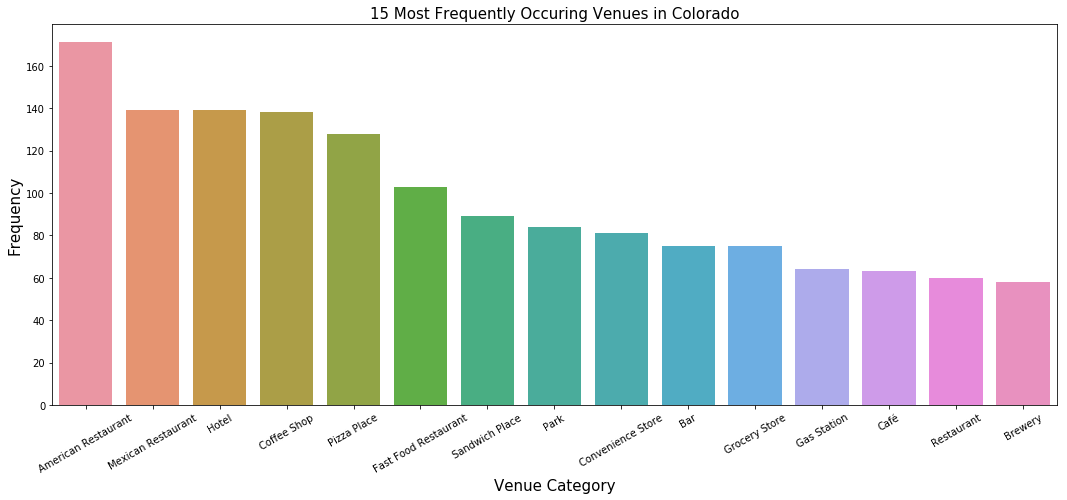

In [280]:
# plot the most common venues in Colorado.

import seaborn as sns
fig = plt.figure(figsize=(18,7))
s=sns.barplot(x="Venue_Category", y="Frequency", data=Denver_Venues_Top15)
s.set_xticklabels(s.get_xticklabels(), rotation=30)
plt.title('15 Most Frequently Occuring Venues in Colorado', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues.png", dpi=300)
plt.show()

In [281]:
# df_boulder = areas_of_interest[areas_of_interest['Municipality'] == 'City of Boulder']
# df_castle = areas_of_interest[areas_of_interest['Municipality'] == 'Town of Castle Rock']
# df_lone = areas_of_interest[areas_of_interest['Municipality'] == 'City of Lone Tree']

# top left corner of bounding box
ndx_of_intrest_boulder = areas_of_interest['Place Name'] == 'Boulder'
boulder_lat = areas_of_interest['Latitude'][ndx_of_intrest_boulder].values[0]
boulder_lon = areas_of_interest['Longitude'][ndx_of_intrest_boulder].values[0]

# bottom right corner of bounding box
ndx_of_intrest_parker = areas_of_interest['Place Name'] == 'Parker'
parker_lat = areas_of_interest['Latitude'][ndx_of_intrest_parker].values[0]
parker_lon = areas_of_interest['Longitude'][ndx_of_intrest_parker].values[0]


idx_lat = np.logical_and(areas_of_interest['Latitude'] <= boulder_lat, areas_of_interest['Latitude'] >= parker_lat)
idx_lon = np.logical_and(areas_of_interest['Longitude'] >= boulder_lon, areas_of_interest['Longitude'] <= parker_lon)
areas_of_interest_filtered = areas_of_interest[np.logical_and(idx_lat, idx_lon)].reset_index(drop=True)

createMapView(areas_of_interest_filtered)

The geograpical coordinate of Denver is 39.7392364, -104.9848623.


In [282]:
denver_msa_venues_filtered = getNearbyVenues(names=areas_of_interest_filtered['Place Name'],
                                   latitudes=areas_of_interest_filtered['Latitude'],
                                   longitudes=areas_of_interest_filtered['Longitude'])

Your credentails:
CLIENT_ID: 1RAZZUPP43HZQWU5GVPVQMW3SJMCAISY40PU1HKUADFKQE5Y
CLIENT_SECRET:XJHXGVLZNXIFJVEUMBJPN14P0EU0X3ZSKNSUKYUBTZY4YENR


In [283]:
# create a dataframe of top 15 categories in Colorado.
Denver_Venues_Top15_filt = denver_msa_venues_filtered['Venue_Category'].value_counts()[0:15].to_frame(name='Frequency')
Denver_Venues_Top15_filt = Denver_Venues_Top15_filt.reset_index()


Denver_Venues_Top15_filt.rename(index=str, columns={"index": "Venue_Category", "Frequency": "Frequency"}, inplace=True)
Denver_Venues_Top15_filt

,Venue_Category,Frequency
0,Mexican Restaurant,46
1,Coffee Shop,39
2,Pizza Place,37
3,Park,33
4,Fast Food Restaurant,33
5,Sandwich Place,31
6,Hotel,29
7,Convenience Store,25
8,American Restaurant,22
9,Gym / Fitness Center,19


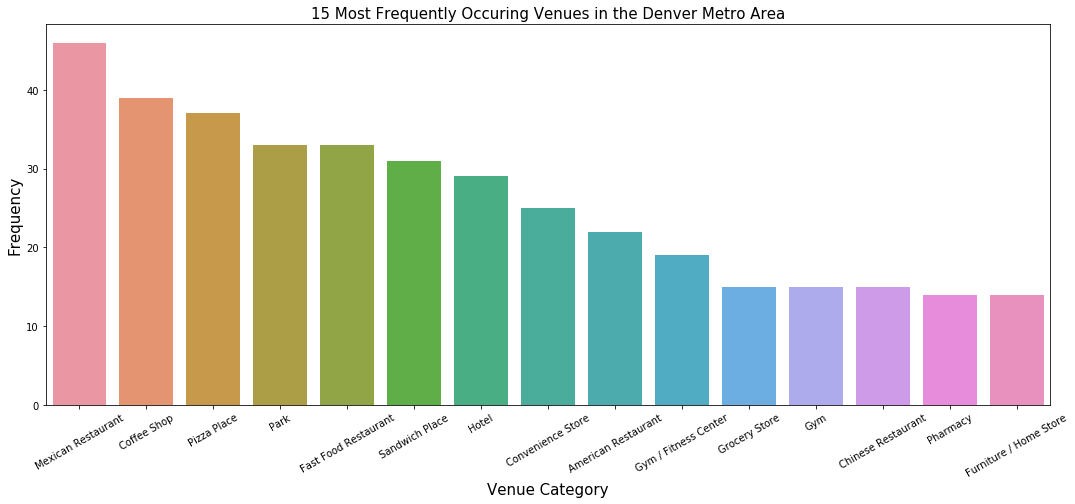

In [287]:
# plot the most common venues in Colorado.

import seaborn as sns
figab = plt.figure(figsize=(18,7))
ab=sns.barplot(x="Venue_Category", y="Frequency", data=Denver_Venues_Top15_filt)
ab.set_xticklabels(ab.get_xticklabels(), rotation=30)
plt.title('15 Most Frequently Occuring Venues in the Denver Metro Area', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues_Denver.png", dpi=300)
plt.show(ab)